In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as md
import matplotlib.pyplot as plt

MEASUREMENTS = "Corrected Upscaled Measurement [MW]"

def plot_dataset(file: str, month: str, outputfile: str):
    data = pd.read_excel(file, skiprows=3)
    data['DateTime'] = pd.to_datetime(data['DateTime'], format = '%d/%m/%Y %H:%M')
    fig, ax = plt.subplots()
    sns.lineplot(ax = ax, data=data, x=data["DateTime"], y=data[MEASUREMENTS]).set_title(f"Recurring patterns in solar power for {month}")
    ax.xaxis.set_major_locator(md.DayLocator(interval = 1))
    ax.xaxis.set_major_formatter(md.DateFormatter('%d'))
    plt.setp(ax.xaxis.get_majorticklabels(), rotation = 0)
    ax.tick_params(axis = 'x', which = 'major', length = 10)
    ax.set_xlim(data['DateTime'].min(), data['DateTime'].max())
    ax.set_ylim([0, 6000])
    ax.set_xlabel(f"Day of month ({month})")
    fig.savefig(outputfile)


In [2]:
def viz_attention(inputs, attention, encoder_type: str, freq: str, layers: int, heads: int, fe: int):
    rows = (layers + 1) // 2 + (layers + 1) % 2
    fig = plt.figure(figsize=(15, 5 * rows))

    ax0 = fig.add_subplot(rows, 2, (1, 2))
    ax0.plot(inputs[0][0], label="Data")
    ax0.legend(title="Input Data", loc="best")
    ax0.set_title(f"Input Data (agg {freq}, {layers} layers, {heads} heads, {fe} fe)")

    for i in range(layers):
        position = i + 3

        ax = fig.add_subplot(rows, 2, position)

        # .mean(dim=-1): Extract mean attention for the current layer
        # [layer][batch]
        print(f"shape {attention[i][0].shape}")
        ax.plot(attention[i][-1].mean(dim=-1), label=f'Layer {i+1}')

        ax.legend(title=f"Layer {i+1}", loc="best")
        ax.set_title(f"Attention Weights for Layer {i+1}")

    plt.tight_layout()
    plt.savefig(f'./figures/attention_{filename_part(encoder_type, freq, layers, heads, fe)}.png')
    plt.show()


load model from ./weights/elia-base-transformer-freq4h-layers2-heads4-fe256_model_last_epoch.pth
model loaded succesfully


c:\Repositories\OpenUniversiteit\dne\code\datasets.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[self.target_column] = self.scaler.fit_transform(df[[self.target_column]]).flatten()


shape torch.Size([30, 512])
shape torch.Size([30, 512])


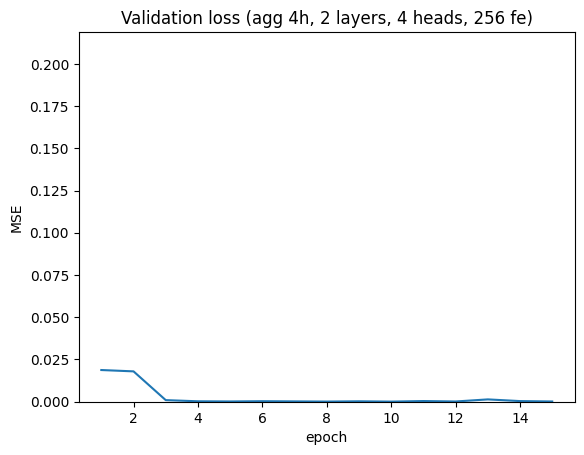

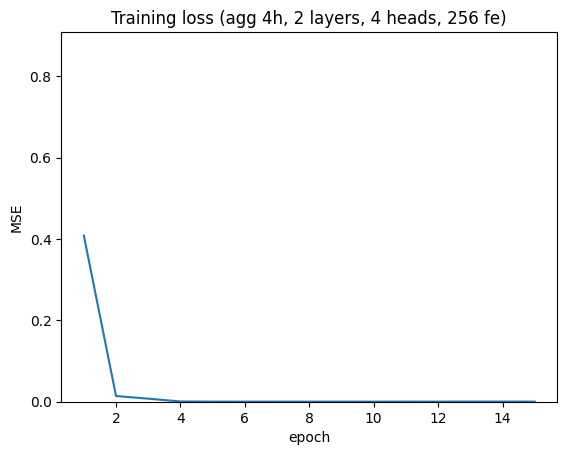

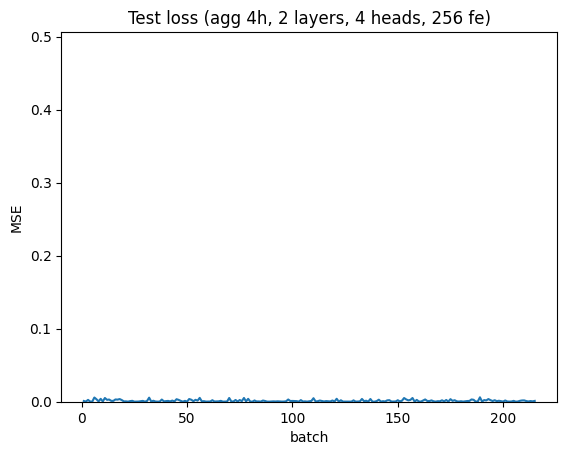

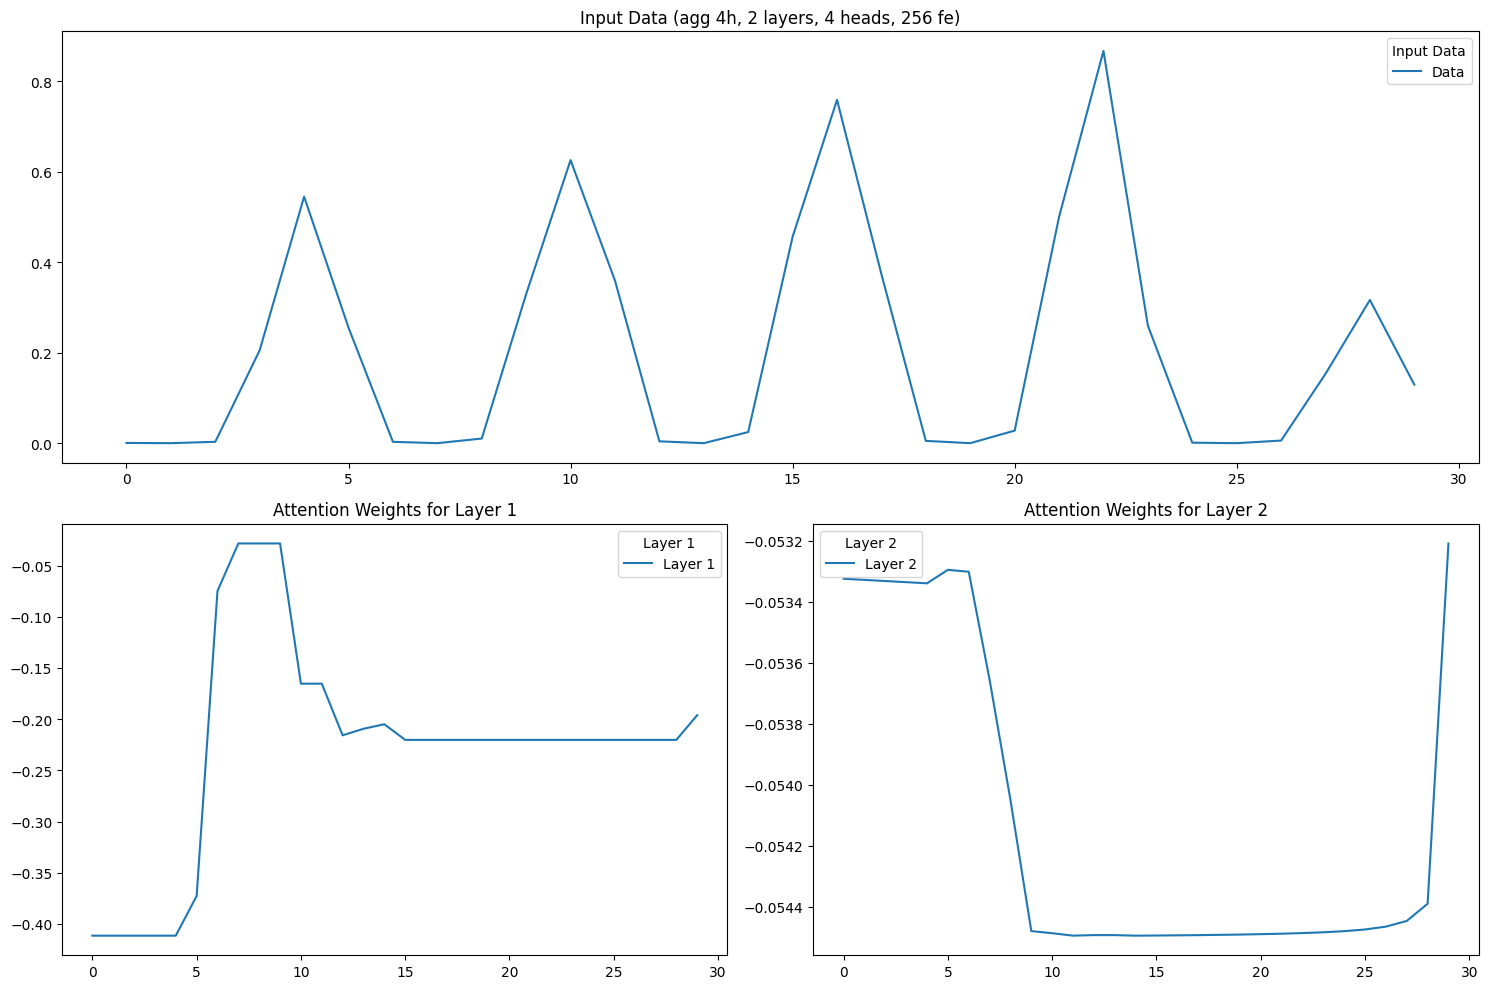

load model from ./weights/elia-base-transformer-freqD-layers2-heads4-fe256_model_last_epoch.pth
model loaded succesfully


c:\Repositories\OpenUniversiteit\dne\code\datasets.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[self.target_column] = self.scaler.fit_transform(df[[self.target_column]]).flatten()


shape torch.Size([30, 512])
shape torch.Size([30, 512])


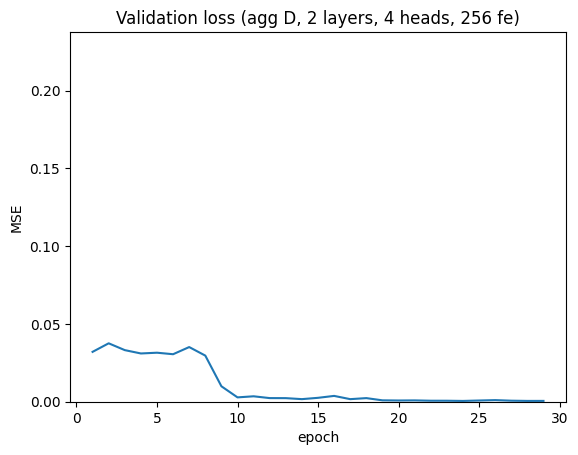

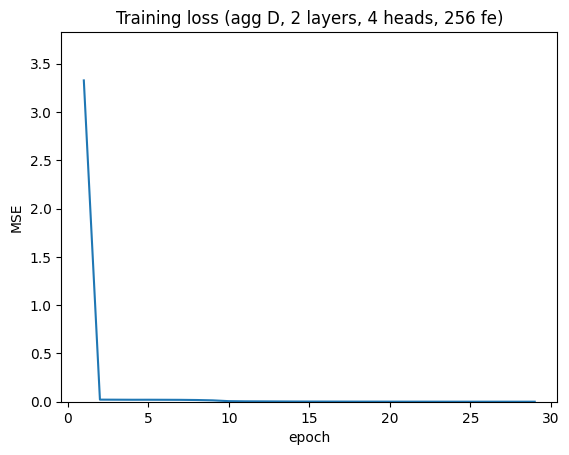

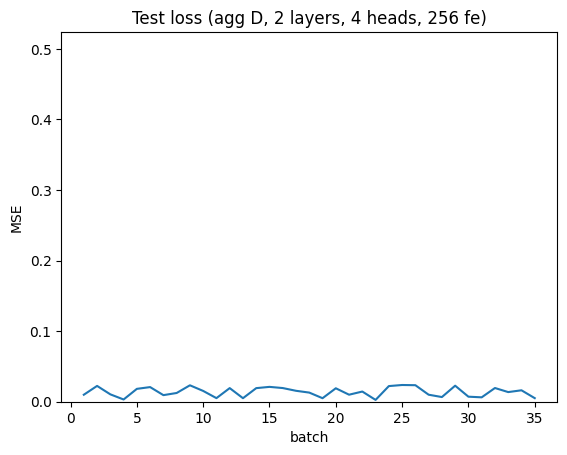

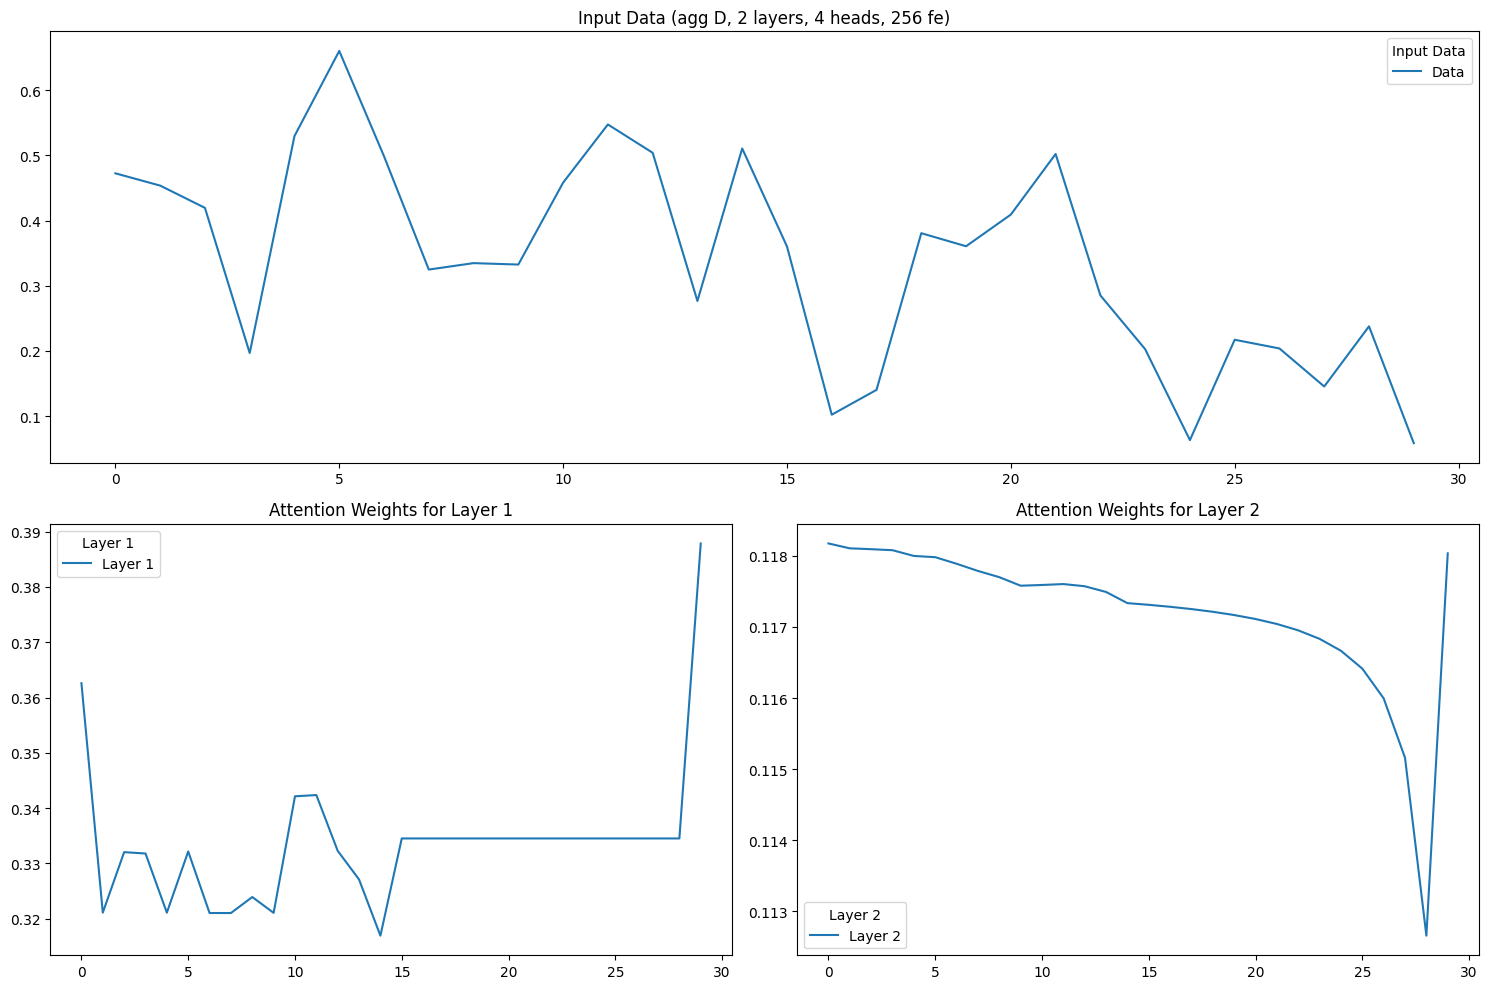

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.dates as md
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
from typing import *
import os
import building_blocks
from utils import ConfigSettings


from importlib import reload
reload(building_blocks)
from building_blocks import *

def figure_filename(kind: str, freq: str, layers: int, heads: int, fe: int) -> str:
    return f"./figures/{kind}-loss-{filename_part(encoder_type, freq, layers, heads, fe)}.png"
    
def plot_train_validation_loss(file: str, freq: str, layers: int, heads: int, fe: int):
    data = pd.read_pickle(file)
    data['epoch'] = pd.Series([int(x) + 1 for x in range(len(data))])
    
    fig, ax = plt.subplots()
    g = sns.lineplot(ax = ax, data=data, x='epoch', y='validation')
    g.set_title(f"Validation loss (agg {freq}, {layers} layers, {heads} heads, {fe} fe)")
    g.set_ylabel("MSE")
    g.set_ylim([0, np.max(data['validation']) + 0.2])
    fig.savefig(figure_filename("validation", freq, layers, heads, fe), bbox_inches='tight')
    
    fig, ax = plt.subplots()
    g = sns.lineplot(ax = ax, data=data, x='epoch', y='training')
    g.set_title(f"Training loss (agg {freq}, {layers} layers, {heads} heads, {fe} fe)")
    g.set_ylabel("MSE")
    g.set_ylim([0, np.max(data['training']) + 0.5])
    fig.savefig(figure_filename("training", freq, layers, heads, fe), bbox_inches='tight')

def plot_test_loss(file: str, freq: str, layers: int, heads: int, fe: int):
    data = pd.read_pickle(file)
    data['batch'] = pd.Series([int(x) + 1 for x in range(len(data))])
    
    fig, ax = plt.subplots()
    g = sns.lineplot(ax = ax, data=data, x='batch', y='test')
    g.set_title(f"Test loss (agg {freq}, {layers} layers, {heads} heads, {fe} fe)")
    g.set_ylabel("MSE")
    g.set_ylim([0, np.max(data['test']) + 0.5])
    fig.savefig(figure_filename("test", freq, layers, heads, fe))


device = "cuda" if torch.cuda.is_available() else "cpu"
frequencies = ["4h", "D"]
layers = [2]
heads = [4]
forward_expansions = [256]
encoder_type = "FourierEncoder"
cf = ConfigSettings(config_path='config.ini')
for freq, layer, head, forward_expansion in ([(frequency, num_layer, head, forward_expansion) for frequency in frequencies for num_layer in layers for head in heads for forward_expansion in forward_expansions]):
    train_val_losses = f"./weights/elia-base-transformer-freq{freq}-layers{layer}-heads{head}-fe{forward_expansion}_train_val_losses.pkl"
    test_losses = f"./weights/elia-base-transformer-freq{freq}-layers{layer}-heads{head}-fe{forward_expansion}_test_losses.pkl"
    if (not os.path.exists(train_val_losses)):
        print(f"could not find validation and training losses {train_val_losses}")
    else:
        plot_train_validation_loss(train_val_losses, freq, layer, head, forward_expansion)
    if (not os.path.exists(test_losses)):
        print(f"could not find test losses {test_losses}")
    else:
        plot_test_loss(test_losses, freq, layer, head, forward_expansion)
    
    model_last_epoch = f"./weights/elia-base-transformer-freq{freq}-layers{layer}-heads{head}-fe{forward_expansion}_model_last_epoch.pth"
    if (not os.path.exists(model_last_epoch)):
        print(f"could not find model last epoch {model_last_epoch}")
    else:
        model_params = generate_model_params(cf, device, encoder_type, layer, head, forward_expansion)
        model = TimeSeriesTransformer.from_params(model_params).to(device)
        print(f"load model from {model_last_epoch}")
        model.load_state_dict(torch.load(model_last_epoch))
        print(f"model loaded succesfully")

        (_, _, test_loader, _) = generate_loaders(cf, freq)

        for input, _ in test_loader:
            model.eval()
            with torch.no_grad():
                _, attention_weights = model(input)
                viz_attention(input, attention_weights, encoder_type, freq, layer, head, forward_expansion)
            break

